In [1]:
!pip install  python-gdcm -q
!pip install pylibjpeg pylibjpeg-libjpeg pydicom -q
!pip install pillow -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import re
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
import glob 
import tqdm
from pydicom import dcmread
from pydicom.data import get_testdata_file
import PIL
import gdcm

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file and apply some preprocessing to return image pixel from (0-255)
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    
    return data


def show_single_image(img, cmap='gray'):
    """A function take an image array and show it as an image with color map you want"""
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    

In [4]:
epochs = 10
batch_size = 16
image_size = (512, 512)
seed = 42

In [5]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# the input root folder 
data_dir = "../input/rsna-2022-cervical-spine-fracture-detection/"

In [7]:
# lets list the contents inside the root folder
os.listdir(data_dir)

['sample_submission.csv',
 'train_images',
 'train_bounding_boxes.csv',
 'segmentations',
 'train.csv',
 'test.csv',
 'test_images']

In [10]:
# look at what is in the train.csv
train_df = pd.read_csv(data_dir + "train.csv")
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [11]:
train_df.iloc[:, 2:].sum()

C1    146
C2    285
C3     73
C4    108
C5    162
C6    277
C7    393
dtype: int64

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  2019 non-null   object
 1   patient_overall   2019 non-null   int64 
 2   C1                2019 non-null   int64 
 3   C2                2019 non-null   int64 
 4   C3                2019 non-null   int64 
 5   C4                2019 non-null   int64 
 6   C5                2019 non-null   int64 
 7   C6                2019 non-null   int64 
 8   C7                2019 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 142.1+ KB


In [13]:
# how managgregatey unique study instances do we have
train_df.StudyInstanceUID.nunique()

2019

In [14]:
# select all the dicom files in the study instance
img_list = glob.glob(data_dir + f"/train_images/1.2.826.0.1.3680043.17625/*.dcm")
len(img_list)

239

In [9]:
def data_generator():
    """A function that take a folder path, load dcm file and return image pixel array"""
    for path in img_list:
        data = load_dicom(path)
        yield data

In [10]:
train_dataset = tf.data.Dataset.from_generator(data_generator, output_types=tf.uint8)
train_dataset

2022-11-14 16:06:29.163943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:06:29.165027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:06:29.567436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:06:29.568472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:06:29.569338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

<FlatMapDataset shapes: <unknown>, types: tf.uint8>

In [10]:
#show_single_image(i)

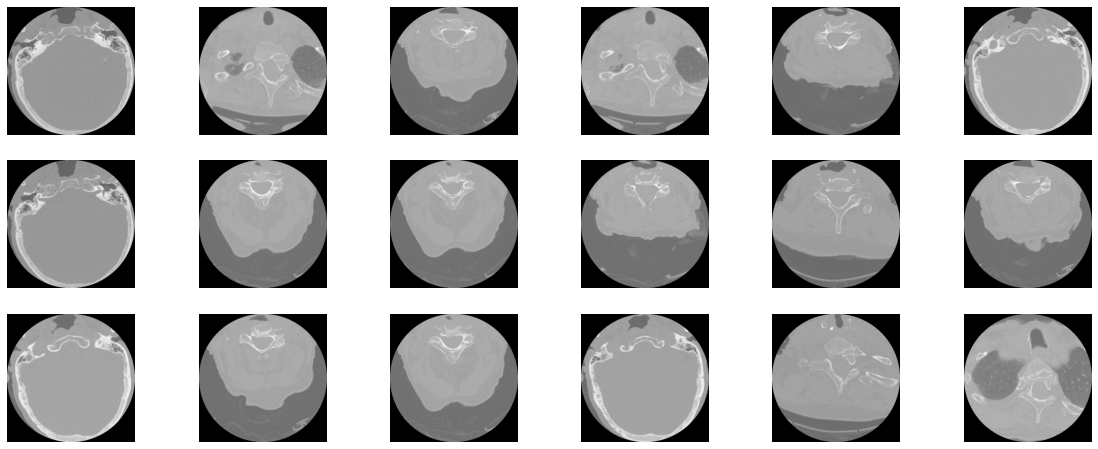

In [17]:
def show_batch(cmap='gray'):
    plt.figure(figsize=(20,8))
    for i, img in enumerate(train_dataset.take(18)):
        plt.subplot(3,6,i+1)
        show_single_image(img, cmap=cmap)
        
show_batch()

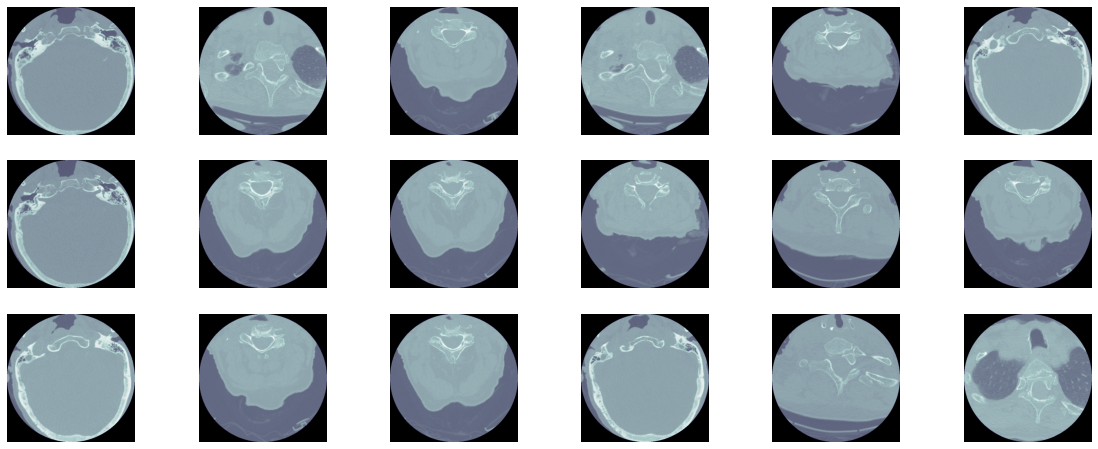

In [18]:
show_batch(cmap='bone')

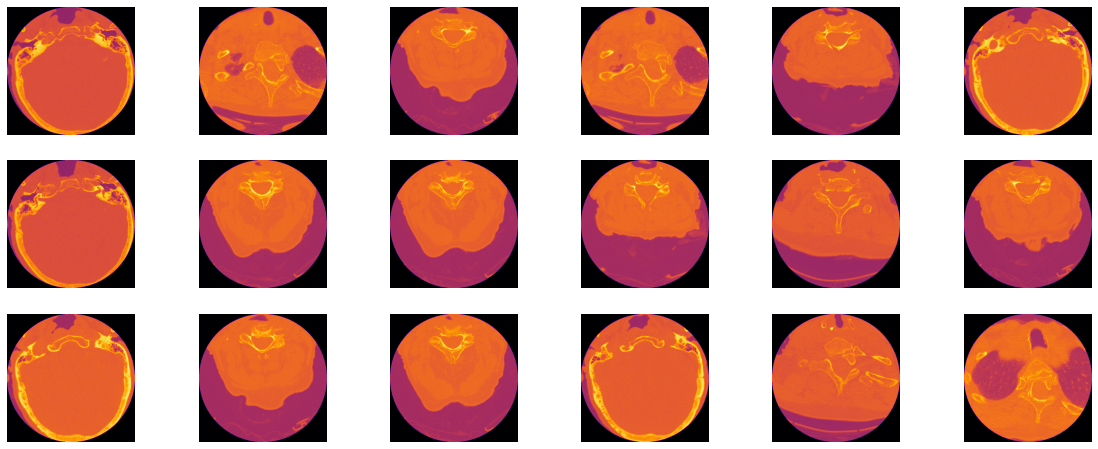

In [19]:
show_batch(cmap='inferno')

In [20]:
train_df = train_df.set_index('StudyInstanceUID')
train_df.head(3)

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


In [24]:
folder_path = glob.glob(data_dir+'train_images/*')
labels = []
all_paths = []
for path in folder_path:
    paths = glob.glob(path+'/*')
    id_num = path.split('/')[-1]
    label = np.tile(list(train_df.loc[id_num][1:].values), (len(paths), 1))
    
    all_paths.extend(paths)
    labels.extend(label)
    

In [25]:
len(labels), len(all_paths)

(711601, 711601)

In [26]:
new_df = pd.DataFrame({'path': all_paths})
new_df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']] = labels

## Start from here

In [8]:
new_df = pd.read_csv("../input/data-with-path/data.csv")
new_df

,path,C1,C2,C3,C4,C5,C6,C7
0,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
1,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
2,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
3,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
4,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
711596,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
711597,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,1
711598,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,1,0
711599,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0


In [9]:
new_df = new_df.sample(frac=1)
new_df

,path,C1,C2,C3,C4,C5,C6,C7
110594,../input/rsna-2022-cervical-spine-fracture-det...,0,1,0,0,0,1,1
626630,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,1,0,0
36704,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
489462,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,1
405353,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
259178,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,1,0
365838,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,1,0,0,0
131932,../input/rsna-2022-cervical-spine-fracture-det...,0,1,0,0,0,0,0
671155,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0


In [10]:
num = int(len(new_df['path'])*0.5)
full_data = new_df.sample(num)
full_data

,path,C1,C2,C3,C4,C5,C6,C7
105045,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
528321,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
386070,../input/rsna-2022-cervical-spine-fracture-det...,1,1,0,0,0,0,0
405683,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
304177,../input/rsna-2022-cervical-spine-fracture-det...,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
686360,../input/rsna-2022-cervical-spine-fracture-det...,0,1,0,0,0,0,0
148608,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,1,0,1
423472,../input/rsna-2022-cervical-spine-fracture-det...,0,1,1,1,0,0,0
273909,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0


In [11]:
full_data = full_data.reset_index(drop=True)
full_data

,path,C1,C2,C3,C4,C5,C6,C7
0,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
1,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
2,../input/rsna-2022-cervical-spine-fracture-det...,1,1,0,0,0,0,0
3,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0
4,../input/rsna-2022-cervical-spine-fracture-det...,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
355795,../input/rsna-2022-cervical-spine-fracture-det...,0,1,0,0,0,0,0
355796,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,1,0,1
355797,../input/rsna-2022-cervical-spine-fracture-det...,0,1,1,1,0,0,0
355798,../input/rsna-2022-cervical-spine-fracture-det...,0,0,0,0,0,0,0


In [12]:
def data_generator():
    for i, path in enumerate(full_data['path']):
        
        train_labels = []
        img = load_dicom(path)
        
        # resize each image into a shape of (512, 512)
        # 256, 256
        img = cv2.resize (img, (256, 256))
            
        #  normalize image
        img = img / 255.0
            
        # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
        img = tf.expand_dims(img, axis=-1)
        img = tf.image.grayscale_to_rgb(img)
            
        train_labels.extend(list(full_data.iloc[i, 1:].values))

        yield img, train_labels

In [13]:
train_data = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8), output_shapes=((256, 256, 3), (7,)))
train_data

2022-11-14 20:56:47.874376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:56:47.875388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:56:48.280555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:56:48.281515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:56:48.282281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

<FlatMapDataset shapes: ((256, 256, 3), (7,)), types: (tf.float32, tf.int8)>

In [14]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

2022-11-14 20:56:53.608182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(256, 256, 3)
(7,)
tf.Tensor([0 0 0 0 0 0 0], shape=(7,), dtype=int8)


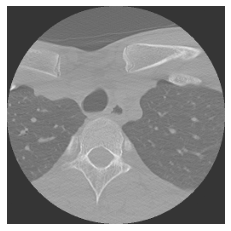

In [15]:
show_single_image(img, cmap='bone')

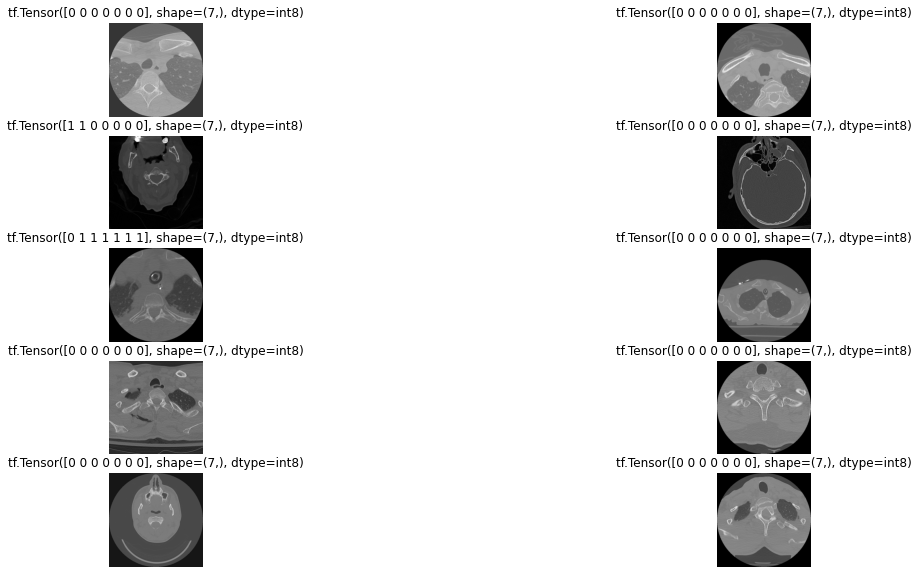

In [16]:
plt.figure(figsize=(20,10))
for i, (img, label) in enumerate(train_data.take(10)):
    plt.subplot(5,2,i+1)
    show_single_image(img, cmap='inferno')
    plt.title(str(label))

In [24]:
# test_shuffle = train_data.shuffle(3, reshuffle_each_iteration=False)
# list(test_shuffle.as_numpy_iterator())

<ShuffleDataset shapes: ((256, 256, 3), (7,)), types: (tf.float32, tf.int8)>

In [30]:
train_data

<FlatMapDataset shapes: ((256, 256, 3), (7,)), types: (tf.float32, tf.int8)>

In [17]:
train_size = int(0.8 * len(full_data)) #569280 files
training = train_data.take(train_size)
validation = train_data.skip(train_size)

In [18]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [19]:
training = configure_for_performance(training)
validation = configure_for_performance(validation)

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [26]:
# def model():
#     model = Sequential()
    
#     model.add(Conv2D(filters=128, input_shape=(256,256,3), kernel_size=(11,11), activation="relu"))
    
#     model.add(Conv2D(filters=256, kernel_size=(11,11), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(BatchNormalization())
    
#     model.add(Conv2D(filters=256, kernel_size=(11,11), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(BatchNormalization())
    
#     model.add(Conv2D(filters=128, kernel_size=(9,9), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(BatchNormalization())
    
#     model.add(Flatten())
#     model.add(Dense(200, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(BatchNormalization())
    
#     model.add(Dense(100, activation="relu"))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    
#     model.add(Dense(7, activation="softmax"))
#     return model

# model = model()

In [21]:
# Let's try a pretrained model
!pip install efficientnet -q

In [22]:
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(256,256,3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=out)

71901184/71892840 [==============================] - 0s 0us/step


In [23]:
len(model.layers)

469

In [24]:
for layer in model.layers[:15]:
    layer.trainable = True
    
for layer in model.layers[10:]:
    layer.trainable = False

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

In [ ]:
history = model.fit(training, validation_data=validation, epochs=20, callbacks=[callback], steps_per_epoch=150, batch_size=64, validation_steps=10)

Epoch 1/20


2022-11-14 20:59:38.896109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - ETA: 0s - loss: 1.3482 - accuracy: 0.1729